In [205]:
import math
from decimal import *
import os
import re
import shutil
import sys
import warnings

import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statistics import median

from constants import bins_axis_names, bin_dimensions_regex, boat_speed_feature, \
                    boxplot_axis_name, feature_regex, identifier_features, \
                    fiber_optics_structure_features, fiber_optics_appendix_features, \
                    other_sensor_features, statistics_features, wind_features

In [206]:
def read_csv(fnames):
    """Read CSV file(s) to a Pandas Dataframe"""
    def detect_and_read(fname):
        with open(fname, 'rb') as f:
            return pd.read_csv(fname, sep=';', encoding=chardet.detect(f.read())['encoding'])
    df = pd.concat(map(lambda fname: detect_and_read(fname), fnames), sort=False)
    return df

def preprocess_data(df,
                identifier_cols=identifier_features,
                cols_to_preprocess=fiber_optics_structure_features + fiber_optics_appendix_features,
                other_cols=other_sensor_features + wind_features + [boat_speed_feature],
                regex=feature_regex):
    preprocessed_df = pd.DataFrame()
    cols = identifier_cols + cols_to_preprocess + other_cols
    exclude = identifier_cols + other_cols
    for old_col, new_col in cols: 
        if (old_col, new_col) in exclude: 
            preprocessed_df[new_col] = df[old_col] 
        else:
            filter_regex = regex.format(old_col) 
            preprocessed_df[new_col] = df.filter(regex=(filter_regex)).mean(axis=1)
    return preprocessed_df

In [351]:
def pol_speed(wind_speed, wind_angle):
    
    pol = pd.read_csv('Polaire.csv',sep=';', )
    
    wind_angle = abs(wind_angle)
    
    if wind_angle < 40:
        wind_angle = 40
    if wind_angle > 160 :
        wind_angle = 160
    
    if wind_speed < 2:
        wind_speed = 2
    if wind_speed > 50:
        wind_speed = 50
    
    for ws in pol:
        if ws == "TWA":
            1
        else:
            if int(ws) <= wind_speed:
                ws_under = int(ws)
            if int(ws) >= wind_speed:
                ws_upper = int(ws)
                break        
    for wd in pol['TWA']:
        if wd <= wind_angle:
            wd_under = wd
        if wd >= wind_angle:
            wd_upper = wd
            break
                        
    if wd_under == wd_upper and ws_under == ws_upper:
        X = pol[pol['TWA'] == wind_angle][str(wind_speed)]
    
    if wd_under != wd_upper and ws_under != ws_upper:
        
        x1 = pol[pol['TWA'] == wd_under][str(ws_under)]
        x2 = pol[pol['TWA'] == wd_under][str(ws_upper)]
        x3 = pol[pol['TWA'] == wd_upper][str(ws_under)]
        x4 = pol[pol['TWA'] == wd_upper][str(ws_upper)]
        

        a = (x2-x1)/(ws_upper-ws_under)
        b = x1-a*ws_under
        x5 = a*wind_speed + b

        a_2 = (x4-x3)/(ws_upper-ws_under)
        b_2 = x3-a_2*ws_under
        x5_2 = a_2*wind_speed + b_2

        A = (float(x5_2)-float(x5))/(wd_upper-wd_under)
        B = x5-A*wd_under
        X = A*wind_angle + B

            
    if wd_under == wd_upper and ws_under != ws_upper:
        
        x1 = pol[pol['TWA'] == wind_angle][str(ws_under)]
        x2 = pol[pol['TWA'] == wind_angle][str(ws_upper)]
        a = (x2-x1)/(ws_upper-ws_under)
        b = x1-a*ws_under
        X = a*wind_speed + b 
            
    if wd_under != wd_upper and ws_under == ws_upper:
        
        x3 = pol[pol['TWA'] == wd_under][str(wind_speed)]
        x4 = pol[pol['TWA'] == wd_upper][str(wind_speed)]  
        a_2 = (float(x4)-float(x3))/(wd_upper-wd_under)
        b_2 = x3-a_2*wd_under
        X = a_2*wind_angle + b_2


    return(X)

In [344]:
# Ignore RunTimeWarning.
warnings.filterwarnings('ignore')

# Ignore PyPlot warning.
plt.rcParams.update({'figure.max_open_warning': 0})

# Version number.
version = 'v2'

In [365]:
#Prend en argument un csv et renvoie un dataframe avec uniquement les données utilisables pour analyser le comportement du bateau
def clean_data(data):
        
    #Transformation du fichier csv en dataframe pandas
    df = read_csv(map(lambda fname: data.format(version, fname), ['data-part-1', 'data-part-2']))
    
    #On renomme les colonnes
    df = preprocess_data(df)
    
    #On supprime les doublons
    df = df.drop_duplicates()
    
    ###############################Suppression des lignes inexploitables#############################################
    
    #Pour avoir le pourcentage de données supprimées
    l1 = len(df)
    
    #On initialise la liste des lignes que l'on va supprimer
    index_to_be_deleted = []
    
    #On y ajoute les données pour lesquelles la GV n'est pas montée et 5 minutes après
    no_Mainsail = df[df['Mainsail_Full'] == 0].index
    for i in no_Mainsail:
        index_to_be_deleted.extend(np.arange(i, i+300))

    #Indices pour lesquels le bateau est face au vent
    ind1 = df[(df["Wind_Angle"] < 40) & (df["Wind_Angle"] > -40)].index
    
    #Indices pour lesquels le bateau est en vent arrière
    ind2 = df[((df["Wind_Angle"] < -170) & (df["Wind_Angle"] > -181)) | ((df["Wind_Angle"] > 170) & (df["Wind_Angle"] < 181))].index
    

    
    #On supprime les données 10 minutes avant et après les manoeuvres
    for i1 in ind1:
        index_to_be_deleted.extend(np.arange(i1-600, i1+600))

    for i2 in ind2:
        index_to_be_deleted.extend(np.arange(i2-600, i2+600))
        

    #On supprime les indices qui apparaissent plusieurs fois
    final_list = list(set(index_to_be_deleted))
    

    
    #On supprime les lignes non pertinentes pour l'analyse du comportement du bateau
    df = df.drop(final_list, errors = 'ignore')

    
    #Indices pour lesquels le bateau avance à une vitesse inférieure à 75% de la polaire
    ind3 = []
    for i in df.index:
        if df['Boat_Speed'][i] < 0.75*float(pol_speed(float(df['Wind_Speed'][i]), float(df['Wind_Angle'][i]))):
            ind3.append(i)
    
    df = df.drop(ind3, errors = 'ignore')
    
    #On réinitialise les indices
    df = df.reset_index(drop = True)

    #Pour avoir le pourcentage de données supprimées
    
    final_list = final_list + ind3
    final_list = list(set(final_list))
    l2 = len(final_list)
    
    #On print le pourcentage de données (lignes) supprimées
    print(Decimal(l2/l1*100).quantize(Decimal('.1'), rounding=ROUND_HALF_UP),'% des données ont été ignorées')
    
    #####################################################################################################################
    
    ###############################Suppression des colonnes inexploitables#############################################

    
    del_columns = []

    #On supprime les colonnes avec des Nan  (-de 50 données exploitables)
    for i in df:
        if df[i].count() < 50 :
            del_columns.append(i)
            df = df.drop(i, 1)
    print('Variables avec trop de Nan :', del_columns)
    
    #On supprime les colonnes qui ne contiennent que des "inf" ou des "-inf" (-de 50 données exploitables)
    col_inf = []
    for i in df.iloc[:,2:]:
        if str(df[i].mean()) == '-inf' or str(df[i].mean()) == 'inf' :
            df = df.drop(i, 1)
            col_inf.append(i)
    print('Variables avec trop de "inf" ou "-inf" :', col_inf)
    
    #On supprime les colonnes qui ne contiennent que des 0 (-de 50 données exploitables)
    col_with_0 = []
    for i in df.iloc[:,2:]:
        count = 0
        for j in df[i]:
            if j != 0.0:
                count+=1
        if count < 50:
            df = df.drop(i, 1)
            col_with_0.append(i)
    print('Variables avec trop de 0 :', col_with_0)
    
    print(len(list(df)), "variables sur", len(list(df))+len(del_columns)+len(col_inf)+len(col_with_0), "sont exploitables")

    ########################################################################################################################
    
    return (df)

In [366]:
df = clean_data('datalog-psm2-181002_857_1440_1Hz.csv')

66.6 % des données ont été ignorées
Variables avec trop de Nan : ['Central_Rudder_Max_Deformation_Port_1', 'Central_Rudder_Max_Deformation_Port_2', 'Central_Rudder_Max_Deformation_Starboard_1', 'Central_Rudder_Max_Deformation_Starboard_2', 'Central_Rudder_Min_Deformation_Port_1', 'Central_Rudder_Min_Deformation_Port_2', 'Central_Rudder_Min_Deformation_Starboard_1', 'Central_Rudder_Min_Deformation_Starboard_2']
Variables avec trop de "inf" ou "-inf" : ['Max_Port_Front_Beam_A1', 'Max_Port_Front_Beam_B1', 'Max_Port_Front_Beam_C1', 'Max_Port_Front_Beam_D1', 'Min_Port_Front_Beam_A1', 'Min_Port_Front_Beam_B1', 'Min_Port_Front_Beam_C1', 'Min_Port_Front_Beam_D1']
Variables avec trop de 0 : ['Max_Port_Front_Beam_A4', 'Max_Port_Front_Beam_B4', 'Max_Port_Front_Beam_C4', 'Max_Port_Front_Beam_D4', 'Max_Port_Front_Beam_A2', 'Max_Port_Front_Beam_B2', 'Max_Port_Front_Beam_C2', 'Max_Port_Front_Beam_D2', 'Max_Port_Front_Beam_A3', 'Max_Port_Front_Beam_B3', 'Max_Port_Front_Beam_C3', 'Max_Port_Front_Beam_D

In [ ]:
def new_var(df):
    
    
    
    if df['Wind_Angle'] < 0:
        
    

In [377]:
df['Foil'] = 0

In [376]:
b = np.zeros(len(df))
df.add(b, axis = 'rows')

ValueError: operands could not be broadcast together with shapes (2609120,) (16307,) 

In [380]:
for i in df:
    print(i)

Date
Hour
Latitude
Longitude
Max_Starboard_Front_Beam_A1
Max_Starboard_Front_Beam_B1
Max_Starboard_Front_Beam_C1
Max_Starboard_Front_Beam_D1
Max_Starboard_Front_Beam_A4
Max_Starboard_Front_Beam_B4
Max_Starboard_Front_Beam_C4
Max_Starboard_Front_Beam_D4
Max_Starboard_Front_Beam_A2
Max_Starboard_Front_Beam_B2
Max_Starboard_Front_Beam_C2
Max_Starboard_Front_Beam_D2
Max_Starboard_Front_Beam_A3
Max_Starboard_Front_Beam_B3
Max_Starboard_Front_Beam_C3
Max_Starboard_Front_Beam_D3
Max_Center_Hull_11
Max_Center_Hull_21
Max_Center_Hull_14
Max_Center_Hull_24
Max_Center_Hull_12
Max_Center_Hull_22
Max_Center_Hull_13
Max_Center_Hull_23
Min_Starboard_Front_Beam_A1
Min_Starboard_Front_Beam_B1
Min_Starboard_Front_Beam_C1
Min_Starboard_Front_Beam_D1
Min_Starboard_Front_Beam_A4
Min_Starboard_Front_Beam_B4
Min_Starboard_Front_Beam_C4
Min_Starboard_Front_Beam_D4
Min_Starboard_Front_Beam_A2
Min_Starboard_Front_Beam_B2
Min_Starboard_Front_Beam_C2
Min_Starboard_Front_Beam_D2
Min_Starboard_Front_Beam_A3
Min_Sta

In [374]:
len(b)

16307

In [94]:
df.head()

,Date,Hour,Latitude,Longitude,Max_Starboard_Front_Beam_A1,Max_Starboard_Front_Beam_B1,Max_Starboard_Front_Beam_C1,Max_Starboard_Front_Beam_D1,Max_Starboard_Front_Beam_A4,Max_Starboard_Front_Beam_B4,...,Selected_Heading,Selected_Heel,Selected_Speed_Over_Ground,Selected_Trim,Wind_Angle,Wind_Direction,Wind_Speed,Apparent_Wind_Angle,Apparent_Wind_Speed,Boat_Speed
0,02/10/2018,06:47:16,47.69672,-3.58124,202.53580,229.34521,237.47253,80.74525,106.00012,146.48784,...,232.76001,5.15,15.33213,0.05,50.26096,283.02097,11.83651,26.0,23.9,15.33213
1,02/10/2018,06:47:17,47.69668,-3.58132,202.15741,232.72682,237.25269,82.99303,111.53599,151.04875,...,232.06000,4.85,15.19822,0.20,50.53564,282.59564,11.83345,26.0,23.8,15.19822
2,02/10/2018,06:47:19,47.69663,-3.58139,219.11041,248.29292,252.78987,90.40900,128.26659,170.79118,...,231.51001,4.81,15.11558,0.21,50.95111,282.46112,11.77596,26.0,23.6,15.11558
3,02/10/2018,06:47:20,47.69658,-3.58146,221.25908,249.55197,252.98294,87.82854,130.84311,171.78294,...,231.01999,4.86,15.03221,-0.05,51.51154,282.53152,11.76357,26.0,23.5,15.03221
4,02/10/2018,06:47:21,47.69653,-3.58153,222.46925,249.24237,252.77032,84.91166,128.07092,169.98279,...,230.63998,4.88,14.92284,-0.14,51.73407,282.37405,11.76625,27.0,23.3,14.92284


In [95]:
df.describe()

,Latitude,Longitude,Max_Starboard_Front_Beam_A1,Max_Starboard_Front_Beam_B1,Max_Starboard_Front_Beam_C1,Max_Starboard_Front_Beam_D1,Max_Starboard_Front_Beam_A4,Max_Starboard_Front_Beam_B4,Max_Starboard_Front_Beam_C4,Max_Starboard_Front_Beam_D4,...,Selected_Heading,Selected_Heel,Selected_Speed_Over_Ground,Selected_Trim,Wind_Angle,Wind_Direction,Wind_Speed,Apparent_Wind_Angle,Apparent_Wind_Speed,Boat_Speed
count,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,...,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000
mean,47.677525,-4.046633,474.425266,491.373756,245.975063,-59.741780,346.726946,367.014705,178.117988,55.069810,...,199.623070,0.708206,21.943942,0.171213,-18.497598,288.267028,15.147824,-7.858382,25.744833,21.943942
std,0.065199,0.354260,231.633114,218.692498,120.419346,196.558564,207.339053,185.591286,146.074360,354.116694,...,104.188159,6.712392,6.167714,0.602051,94.171706,7.460522,1.686220,45.394441,8.147222,6.167714
min,47.537940,-4.943110,-26.280810,-4.894020,-181.277920,-638.222720,-21.337070,21.299340,-249.287320,-786.942440,...,0.170010,-15.900000,6.441800,-3.890000,-163.762950,266.022400,10.799490,-159.000000,5.900000,6.441800
25%,47.632910,-4.245910,313.879490,340.128630,164.226240,-244.504430,182.367630,220.763950,52.291110,-296.214870,...,70.870000,-5.830000,18.920620,-0.160000,-129.684940,283.458860,14.232090,-33.000000,21.300000,18.920620
50%,47.671030,-3.940910,389.509220,420.824860,246.710130,63.269380,247.973660,288.003660,171.839750,154.770190,...,229.480000,0.520000,22.051340,0.200000,-48.621730,288.548920,15.257930,-23.000000,27.400000,22.051340
75%,47.722930,-3.851870,691.959470,693.412110,357.774720,105.215180,565.050230,560.085940,324.940890,403.723300,...,248.989990,6.830000,25.749660,0.540000,52.451680,293.152950,16.207430,26.000000,32.300000,25.749660
max,47.817440,-3.484560,1076.183230,1063.350220,473.480870,199.369490,870.922610,840.496340,450.714690,549.420230,...,358.069980,15.570000,36.382500,2.260000,150.745060,312.463840,20.261560,122.000000,39.900000,36.382500


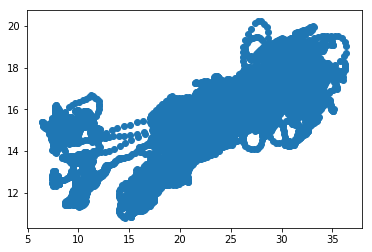

In [110]:
plt.scatter(df['Boat_Speed'], df['Wind_Speed'])

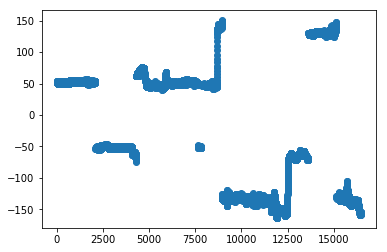

In [97]:
plt.scatter(df['Wind_Angle'].index, df['Wind_Angle'])

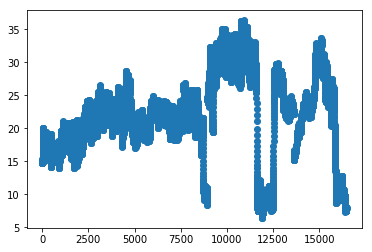

In [98]:
plt.scatter(df['Boat_Speed'].index, df['Boat_Speed'])

In [101]:
df['Wind_Direction'].describe()

count    16481.000000
mean       288.267028
std          7.460522
min        266.022400
25%        283.458860
50%        288.548920
75%        293.152950
max        312.463840
Name: Wind_Direction, dtype: float64

In [9]:
df = read_csv(map(lambda fname: 'datalog-psm2-181002_857_1440_1Hz.csv'.format(version, fname), ['data-part-1', 'data-part-2']))
df = preprocess_data(df)
df = df.drop_duplicates()

In [10]:
pol = pd.read_csv('Polaire.csv',sep=';', )

In [11]:
pol[pol['TWA'] == 40]['2']

0    0.81
Name: 2, dtype: float64

In [12]:
pol['2'][0]

0.81

In [15]:
pol2 = pd.read_csv('Polaire.csv',sep=';', )

In [340]:
def pol_speed(wind_speed, wind_angle):
    
    pol = pd.read_csv('Polaire.csv',sep=';', )
    
    for ws in pol:
        if ws == "TWA":
            1
        else:
            if int(ws) <= wind_speed:
                ws_under = int(ws)
            if int(ws) >= wind_speed:
                ws_upper = int(ws)
                break        
    for wd in pol['TWA']:
        if wd <= wind_angle:
            wd_under = wd
        if wd >= wind_angle:
            wd_upper = wd
            break
                        
    if wd_under == wd_upper and ws_under == ws_upper:
        X = pol[pol['TWA'] == wind_angle][str(wind_speed)]
    
    if wd_under != wd_upper and ws_under != ws_upper:
        
        x1 = pol[pol['TWA'] == wd_under][str(ws_under)]
        x2 = pol[pol['TWA'] == wd_under][str(ws_upper)]
        x3 = pol[pol['TWA'] == wd_upper][str(ws_under)]
        x4 = pol[pol['TWA'] == wd_upper][str(ws_upper)]
        

        a = (x2-x1)/(ws_upper-ws_under)
        b = x1-a*ws_under
        x5 = a*wind_speed + b

        a_2 = (x4-x3)/(ws_upper-ws_under)
        b_2 = x3-a_2*ws_under
        x5_2 = a_2*wind_speed + b_2

        A = (float(x5_2)-float(x5))/(wd_upper-wd_under)
        B = x5-A*wd_under
        X = A*wind_angle + B

            
    if wd_under == wd_upper and ws_under != ws_upper:
        
        x1 = pol[pol['TWA'] == wind_angle][str(ws_under)]
        x2 = pol[pol['TWA'] == wind_angle][str(ws_upper)]
        a = (x2-x1)/(ws_upper-ws_under)
        b = x1-a*ws_under
        X = a*wind_speed + b 
            
    if wd_under != wd_upper and ws_under == ws_upper:
        
        x3 = pol[pol['TWA'] == wd_under][str(wind_speed)]
        x4 = pol[pol['TWA'] == wd_upper][str(wind_speed)]  
        a_2 = (float(x4)-float(x3))/(wd_upper-wd_under)
        b_2 = x3-a_2*wd_under
        X = a_2*wind_angle + b_2


    return(X)

In [341]:
pol_speed_test(22.3, 44)

1    15.755
dtype: float64

In [233]:
pol['TWA'][2]

46

In [381]:
pol_speed(22, 42)

0    13.71
Name: 22, dtype: float64